# Extracting Forth Insurance Data

In [37]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [ ]:
output_column_names = ['title', 'review', 'date', 'stars']
data1 = pd.DataFrame(columns=output_column_names)

In [ ]:
for i in range(1,11) :
  url = 'https://www.productreview.com.au/listings/aami-car-insurance?page={}#reviews'.format(i)
  page = requests.get(url)
  soup = BeautifulSoup(page.text, "html.parser")
  Reviews = soup.findAll("div", {"class": "mb-0_wJE overflow-hidden_1pr card_12c card-full_1bA card-full-md_1Kd"})
  Reviews1 = []
  for reviewBox in Reviews:
    review_title = reviewBox.find('h3', {"class": "mb-1_2Ff"}).text
    review_text = reviewBox.find('p', {"class": "mb-0_wJE"}).text
    review_date = reviewBox.find("time").attrs['datetime']
    review_stars = reviewBox.find('div', {'class': 'me-1_2lk'}).attrs['title']
    Reviews1.append([review_title, review_text, review_date, review_stars])
  Reviews1 = pd.DataFrame(Reviews1, columns=output_column_names)
  data1 = data1.append(Reviews1)  

In [ ]:
print(len(data1))

215


In [ ]:
data1.to_csv('aami_reviews.csv', index=None)

In [ ]:
data1.head(5)

,title,review,date,stars
0,Worst insurance company I’ve ever dealt with,This has got to be the worst insurance company...,2021-09-12T00:26:40.000Z,1 out of 5 stars
1,"Stay away from AAMI, they insist on using afte...",Do not insure your brand new car with AAMI! I ...,2021-09-02T03:35:32.000Z,1 out of 5 stars
2,"Awful, you might aswell throw your money out t...",Made my claim process extremely difficult and ...,2021-09-01T10:58:05.000Z,1 out of 5 stars
3,Always Friendly and Helpful team,I would like to say a Big Thank you to All the...,2021-08-31T09:36:48.000Z,5 out of 5 stars
4,They make it very hard to claim!!!,1. Cant access claim progress online2. Calls l...,2021-08-29T02:53:34.000Z,1 out of 5 stars


# Data Loading

In [1]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 6.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=13facde7f1c2c6d280685130387023b1c8e6386332a674889217192429cde266
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [2]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
budget_direct = pd.read_csv('budget_direct_car_insuarance_reviews.csv')
racv = pd.read_csv('racv_car_insuarance_reviews.csv')
youi = pd.read_csv('youi_car_insuarance_reviews.csv')
aami = pd.read_csv('aami_reviews.csv')

In [4]:
budget_direct['Insurer'] = 'Budget Direct'
racv['Insurer'] = 'RACV'
youi['Insurer'] = 'Youi'
aami['Insurer'] = 'Aami'

In [5]:
combine = pd.concat([budget_direct, racv, youi, aami], ignore_index=True)

# Data Preprocessing

In [6]:
combine['title'] = combine['title'].str.lower()
combine['review'] = combine['review'].str.lower()

In [7]:
def remove_review_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet))
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet))
  return spaces_removed

combine['review'] = combine['review'].apply(remove_review_ids)
combine.tail()

,title,review,date,stars,Insurer
2602,you not lucky with them. false advertise,thumbs down aami,2019-09-18T05:43:10.000Z,1 out of 5 stars,Aami
2603,do not get aami to insure anything you own!,3 weeks ago my partner was in a car accidentwi...,2019-09-12T11:19:41.000Z,1 out of 5 stars,Aami
2604,aami is disgusting,this is an absolute disgusting insurance that ...,2019-09-04T01:58:34.000Z,1 out of 5 stars,Aami
2605,"oh, aami bad!",had an accident but wasnt my fault aami insist...,2019-09-02T00:43:23.000Z,1 out of 5 stars,Aami
2606,if you want to donation then get insurance wit...,helplessbad service long call waitingno good a...,2019-08-30T13:06:02.000Z,1 out of 5 stars,Aami


In [8]:
#Duplicate Removal
duplicate_count = len(combine['review'])-len(combine['review'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', combine.shape[0])

duplicate count: 3
total records before remove duplicates: 2607


In [9]:
combine = combine.drop_duplicates(subset='review', keep="first")
print('updated record count:', combine.shape[0])

updated record count: 2604


In [10]:
#Removal of Punctuations
combine['review'] = combine['review'].str.replace(r'[^\w\s]','')
combine.tail()

,title,review,date,stars,Insurer
2602,you not lucky with them. false advertise,thumbs down aami,2019-09-18T05:43:10.000Z,1 out of 5 stars,Aami
2603,do not get aami to insure anything you own!,3 weeks ago my partner was in a car accidentwi...,2019-09-12T11:19:41.000Z,1 out of 5 stars,Aami
2604,aami is disgusting,this is an absolute disgusting insurance that ...,2019-09-04T01:58:34.000Z,1 out of 5 stars,Aami
2605,"oh, aami bad!",had an accident but wasnt my fault aami insist...,2019-09-02T00:43:23.000Z,1 out of 5 stars,Aami
2606,if you want to donation then get insurance wit...,helplessbad service long call waitingno good a...,2019-08-30T13:06:02.000Z,1 out of 5 stars,Aami


In [11]:
#Stop Words Removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
combine['review'] = combine['review'].apply(remove_stop_words)
combine.tail(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,review,date,stars,Insurer
2602,you not lucky with them. false advertise,thumbs aami,2019-09-18T05:43:10.000Z,1 out of 5 stars,Aami
2603,do not get aami to insure anything you own!,3 weeks ago partner car accidentwith new born ...,2019-09-12T11:19:41.000Z,1 out of 5 stars,Aami
2604,aami is disgusting,absolute disgusting insurance ever understand ...,2019-09-04T01:58:34.000Z,1 out of 5 stars,Aami
2605,"oh, aami bad!",accident wasnt fault aami insist send capital ...,2019-09-02T00:43:23.000Z,1 out of 5 stars,Aami
2606,if you want to donation then get insurance wit...,helplessbad service long call waitingno good a...,2019-08-30T13:06:02.000Z,1 out of 5 stars,Aami


In [12]:
#Standardization of reviews
#Using Lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmtizer = WordNetLemmatizer()
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

combine['sentence_lemmatized'] = combine['review'].apply(lemmatize_function)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
combine.head()

,title,review,date,stars,Insurer,sentence_lemmatized
0,stay away from their roadside assistance,driver took long time arrive apparently due ca...,2021-07-17,2 out of 5 stars,Budget Direct,driver took long time arrive apparently due ca...
1,no! no! no!,cant count number calls made emails sent times,2021-07-17,1 out of 5 stars,Budget Direct,cant count number call made email sent time
2,go for other insurance if you need one,claim took 3m find possible reasons reject cla...,2021-07-16,1 out of 5 stars,Budget Direct,claim took 3m find possible reason reject clai...
3,the good choice i think,take easy call get event online call direct in...,2021-07-16,5 out of 5 stars,Budget Direct,take easy call get event online call direct in...
4,comprehensive car insurance,easy use professional service definitely value...,2021-07-16,5 out of 5 stars,Budget Direct,easy use professional service definitely value...


# Word Frequency Analysis

In [14]:
word_freq = pd.Series(' '.join(combine['review']).split()).value_counts()

In [15]:
word_freq[:10]

car          1396
insurance    1154
policy        971
youi          858
easy          689
service       655
claim         578
budget        562
good          554
value         547
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


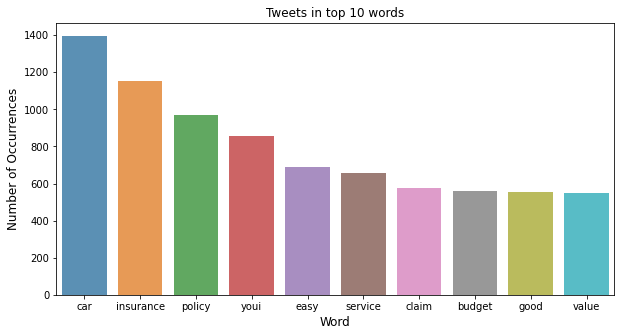

In [16]:
#Visualization of most frequent words
plt.figure(figsize=(10,5))
sns.barplot(word_freq[:10,].index, word_freq[:10,].values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

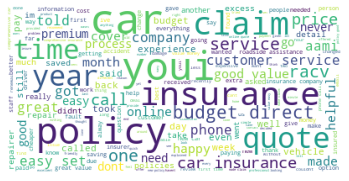

In [17]:
#Word Corpus creation
from PIL import Image
from wordcloud import WordCloud

corpus = list(combine['review'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
#Common words are there which are expected to be there. 
#So we are now removing the common words and again run the word frequency analysis and corpus creation.
remove = ["car", "youi", "insurance", "policy", "claim", "quote", "budget direct", "budget", "direct"]
combine['review'] = combine['review'].apply(lambda x: " ".join(x for x in x.split() if x not in remove))
combine.head(5)

,title,review,date,stars,Insurer,sentence_lemmatized
0,stay away from their roadside assistance,driver took long time arrive apparently due ca...,2021-07-17,2 out of 5 stars,Budget Direct,driver took long time arrive apparently due ca...
1,no! no! no!,cant count number calls made emails sent times,2021-07-17,1 out of 5 stars,Budget Direct,cant count number call made email sent time
2,go for other insurance if you need one,took 3m find possible reasons reject even thin...,2021-07-16,1 out of 5 stars,Budget Direct,claim took 3m find possible reason reject clai...
3,the good choice i think,take easy call get event online call insureran...,2021-07-16,5 out of 5 stars,Budget Direct,take easy call get event online call direct in...
4,comprehensive car insurance,easy use professional service definitely value...,2021-07-16,5 out of 5 stars,Budget Direct,easy use professional service definitely value...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


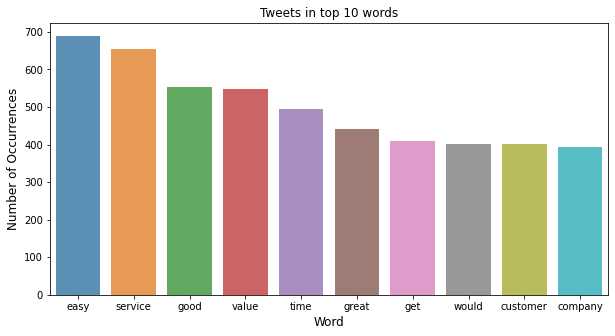

In [19]:
word_freq = pd.Series(' '.join(combine['review']).split()).value_counts()
plt.figure(figsize=(10,5))
sns.barplot(word_freq[:10,].index, word_freq[:10,].values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

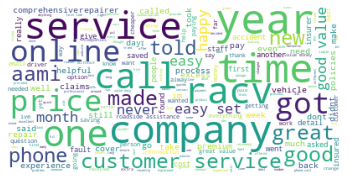

In [20]:
corpus = list(combine['review'])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Bigrams Analysis

In [21]:
def get_ngrams(corpus, ngram_range=(2, 2)):
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [22]:
bigrams = get_ngrams(combine['review'].tolist(), ngram_range=(2, 2))
bigrams = pd.DataFrame(bigrams)
bigrams.columns=["Bi-gram", "Freq"]

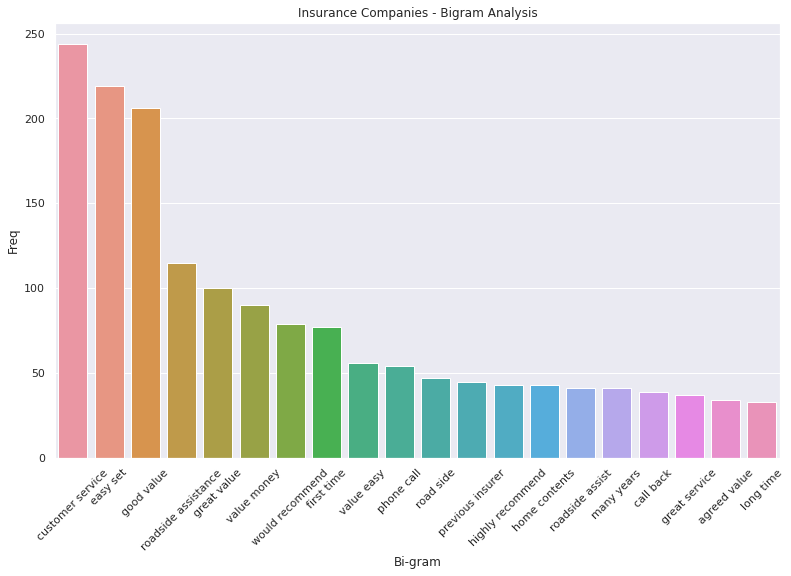

In [23]:
freq = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams[:freq])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.title('Insurance Companies - Bigram Analysis')
plt.show()

# Trigrams Analysis

In [24]:
trigrams = get_ngrams(combine['review'].tolist(), ngram_range=(3, 3))
trigrams = pd.DataFrame(trigrams)
trigrams.columns=["Tri-gram", "Freq"]

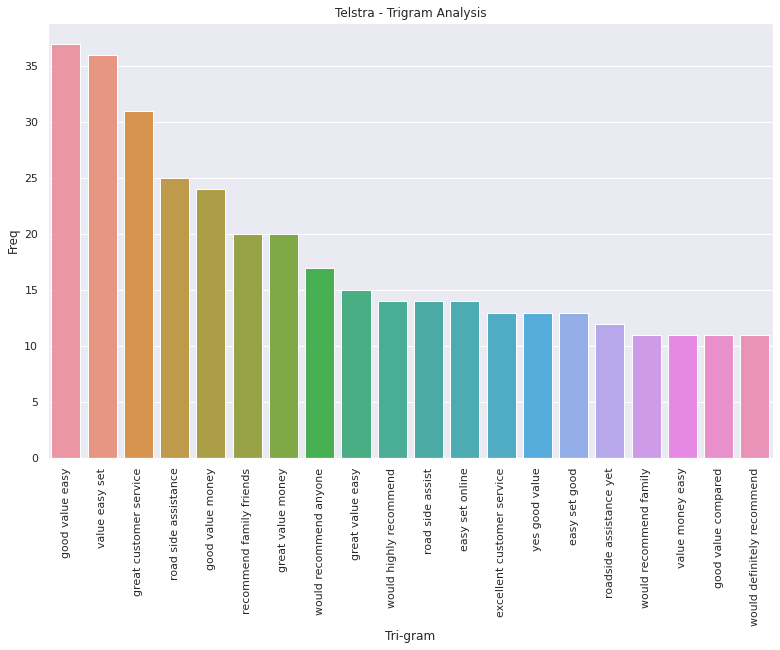

In [25]:
#Trigrams Visualization
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams[:freq])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Telstra - Trigram Analysis')
plt.show()

# Temporal Analysis

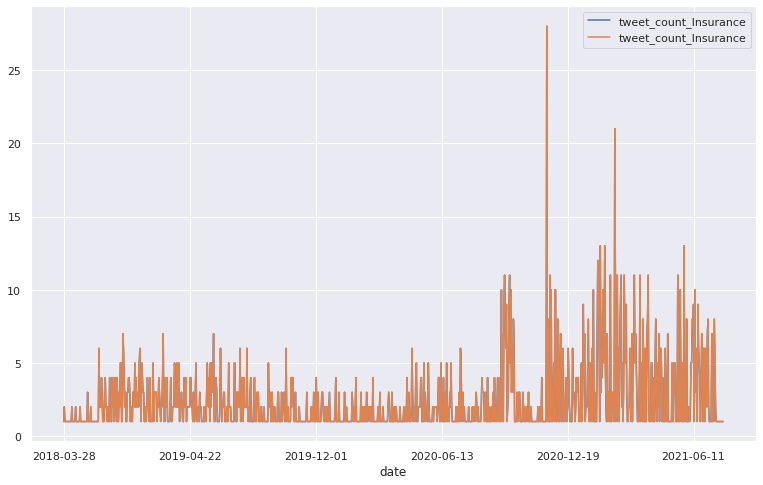

In [26]:
combine_datewise = combine.groupby(['date'])['review'].count().reset_index(name='tweet_count_Insurance').set_index('date')
ax = combine_datewise.plot()
combine_datewise.plot(ax=ax)
plt.savefig('temporal_analysis.png', dpi=800)

# Sentiment Analysis

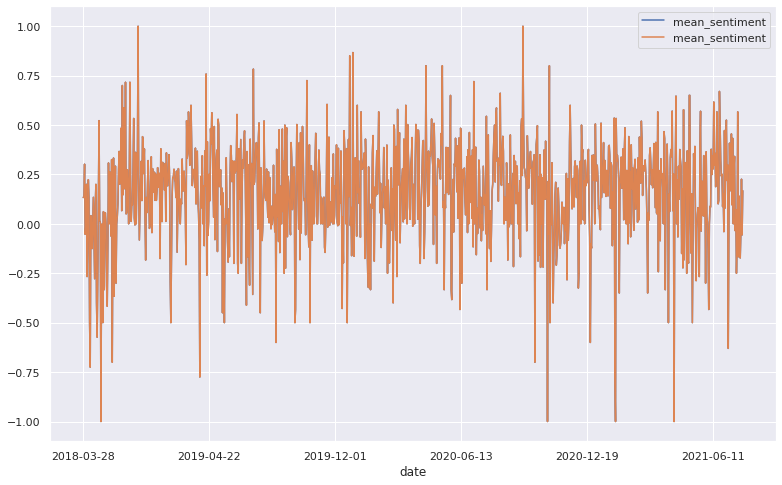

In [27]:
combine['sentiment'] = combine['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
combine_senti_datewise = combine.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment').set_index('date')
ax = combine_senti_datewise.plot()
combine_senti_datewise.plot(ax=ax)
plt.savefig('temporal_sentiment_v2.png', dpi=800)

# Topic Modelling

In [28]:
#Environment for modelling
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [29]:
corpus = list(combine['review'])
corpus[:5]

['driver took long time arrive apparently due call baby locked understandably took priority however one driver available brisbanealso battery expensive 290 plus membership plus 100 call fee would use',
 'cant count number calls made emails sent times',
 'took 3m find possible reasons reject even things possible cant proof example left keys immediate vicinity keys recently cut etc terms immediate vicinity recently doggy terms beware',
 'take easy call get event online call insurerance easer think help thing want thank much',
 'easy use professional service definitely value money took time complete online great followup service pleased far thank much cheers']

In [30]:
#Token
combine_texts = [[word for word in str(document).split()] for document in corpus]
dictionary = corpora.Dictionary(combine_texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'combine.dict'))

print(combine_texts[0])
print('alphabetically sorted', sorted(combine_texts[0]))

2021-09-12 07:29:56,623 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-12 07:29:56,715 : INFO : built Dictionary(7448 unique tokens: ['100', '290', 'apparently', 'arrive', 'available']...) from 2604 documents (total 62243 corpus positions)
2021-09-12 07:29:56,717 : INFO : saving Dictionary object under /tmp/combine.dict, separately None
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
2021-09-12 07:29:56,727 : INFO : saved /tmp/combine.dict


['driver', 'took', 'long', 'time', 'arrive', 'apparently', 'due', 'call', 'baby', 'locked', 'understandably', 'took', 'priority', 'however', 'one', 'driver', 'available', 'brisbanealso', 'battery', 'expensive', '290', 'plus', 'membership', 'plus', '100', 'call', 'fee', 'would', 'use']
alphabetically sorted ['100', '290', 'apparently', 'arrive', 'available', 'baby', 'battery', 'brisbanealso', 'call', 'call', 'driver', 'driver', 'due', 'expensive', 'fee', 'however', 'locked', 'long', 'membership', 'one', 'plus', 'plus', 'priority', 'time', 'took', 'took', 'understandably', 'use', 'would']


In [31]:
print(dictionary.token2id)

{'100': 0, '290': 1, 'apparently': 2, 'arrive': 3, 'available': 4, 'baby': 5, 'battery': 6, 'brisbanealso': 7, 'call': 8, 'driver': 9, 'due': 10, 'expensive': 11, 'fee': 12, 'however': 13, 'locked': 14, 'long': 15, 'membership': 16, 'one': 17, 'plus': 18, 'priority': 19, 'time': 20, 'took': 21, 'understandably': 22, 'use': 23, 'would': 24, 'calls': 25, 'cant': 26, 'count': 27, 'emails': 28, 'made': 29, 'number': 30, 'sent': 31, 'times': 32, '3m': 33, 'beware': 34, 'cut': 35, 'doggy': 36, 'etc': 37, 'even': 38, 'example': 39, 'find': 40, 'immediate': 41, 'keys': 42, 'left': 43, 'possible': 44, 'proof': 45, 'reasons': 46, 'recently': 47, 'reject': 48, 'terms': 49, 'things': 50, 'vicinity': 51, 'easer': 52, 'easy': 53, 'event': 54, 'get': 55, 'help': 56, 'insurerance': 57, 'much': 58, 'online': 59, 'take': 60, 'thank': 61, 'thing': 62, 'think': 63, 'want': 64, 'cheers': 65, 'complete': 66, 'definitely': 67, 'far': 68, 'followup': 69, 'great': 70, 'money': 71, 'pleased': 72, 'professional'

In [32]:
corpus = [dictionary.doc2bow(text) for text in combine_texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus] 
total_topics = 40
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]
lda.show_topics(total_topics, num_words=6)
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2021-09-12 07:30:00,511 : INFO : collecting document frequencies
2021-09-12 07:30:00,513 : INFO : PROGRESS: processing document #0
2021-09-12 07:30:00,534 : INFO : calculating IDF weights for 2604 documents and 7447 features (57483 matrix non-zeros)
2021-09-12 07:30:00,559 : INFO : using symmetric alpha at 0.025
2021-09-12 07:30:00,562 : INFO : using symmetric eta at 0.025
2021-09-12 07:30:00,569 : INFO : using serial LDA version on this node
2021-09-12 07:30:00,614 : INFO : running online (single-pass) LDA training, 40 topics, 1 passes over the supplied corpus of 2604 documents, updating model once every 2000 documents, evaluating perplexity every 2604 documents, iterating 50x with a convergence threshold of 0.001000
2021-09-12 07:30:00,615 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-09-12 07:30:00,624 : INFO : PROGRESS: pass 0, at document #2000/2604
2021-09-12 07:30:02,157 : INFO : merging 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
11     -34.524910  -38.297638       1        1  11.647360
13      -6.063464   68.416847       2        1   5.126438
36     106.410477  -24.926636       3        1   4.337150
34      28.976225   79.651184       4        1   3.975191
16     133.116104  -65.075333       5        1   3.733778
8       -0.919831  -44.023651       6        1   3.632833
20     -52.560081  -73.819885       7        1   3.592107
22     -89.020752   -7.289051       8        1   3.269654
24     -77.229332  -42.920933       9        1   3.170756
5      -89.499397  -91.887329      10        1   3.105342
10      -0.318477   23.023058      11        1   2.964987
35      69.150108   62.564991      12        1   2.868621
14     -54.327969  -12.113202      13        1   2.760664
28      79.404732 -112.676018      14        1   2.746732
21    -126.103279  -49.035183      15        1   2.582117
27     -67.105469  140.170868      16        1   2.294537
12     -50.580238 -126.012016      17        1   2.262550
31     -41.567066   95.642273      18        1   2.061964
15     115.865593   69.828011      19        1   1.991101
7      -63.652939   21.310493      20        1   1.830891
18       7.578788  -11.323202      21        1   1.825515
32      11.644083 -121.927406      22        1   1.808830
37      33.631664  -76.378891      23        1   1.728288
33      33.217293  -37.921047      24        1   1.598837
0      -36.402893   43.972904      25        1   1.570345
6      -26.330301    1.485044      26        1   1.550501
2       30.796810   37.537586      27        1   1.509001
9        3.715915  132.074463      28        1   1.503553
23    -126.737625   91.571091      29        1   1.491990
39     100.893059   21.004021      30        1   1.456765
19    -158.294815   42.052635      31        1   1.454650
30      64.283073   22.282240      32        1   1.443887
1       65.570282  -14.470222      33        1   1.414281
3       33.466496    2.941962      34        1   1.395379
38      -9.438610  -81.958572      35        1   1.393091
25     -84.507324   58.649590      36        1   1.381639
17     148.767288   15.310841      37        1   1.379669
26      73.419693  -62.176243      38        1   1.379669
29    -127.834358   12.610479      39        1   1.379669
4       68.449944  115.980125      40        1   1.379669, topic_info=            Term       Freq      Total Category  logprob  loglift
645         aami  22.000000  22.000000  Default  30.0000  30.0000
74       service  19.000000  19.000000  Default  29.0000  29.0000
122         good  11.000000  11.000000  Default  28.0000  28.0000
145        years  13.000000  13.000000  Default  27.0000  27.0000
53          easy  13.000000  13.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
100      helpful   0.166704   7.630759  Topic40  -5.1631   0.4596
165      premium   0.160839   4.623693  Topic40  -5.1989   0.9248
291        still   0.155552   4.015655  Topic40  -5.2324   1.0323
531  information   0.146743   3.344461  Topic40  -5.2907   1.1570
71         money   0.145530   8.058811  Topic40  -5.2990   0.2692

[2616 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
441       1  0.270322     10
441       7  0.270322     10
1217      1  0.923524     13
520       1  0.218263      3
111       5  0.405532      4
...     ...       ...    ...
145       8  0.075287  years
145       9  0.075287  years
145      11  0.075287  years
145      23  0.075287  years
250       3  0.361068    yet

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 37, 35, 17, 9, 21, 23, 25, 6, 11, 36, 15, 29, 22, 28, 13, 32, 16, 8, 19, 33, 38, 34, 1, 7, 3, 10, 24, 40, 20, 31, 2, 4, 39, 26, 18, 27, 30, 5])